In [9]:
import numpy as np 
import uproot as ur
import matplotlib.pyplot as plt

import pickle

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler
#from sklearn.utils import resample
#from utils import Logger, make_file_name, save_model, logloss_plot, auc_plot, aucpr_plot, roc_curve, pr_curve

In [21]:
class RareDecayBDTClassifier:
    def __init__(self,
                 model_params = None,
                 log_scaling = None,
                 normalization = None,
                 hyperparameters=None):
        ''''
        Initializing the default model with no scaling and normalization on the data
        (hyperparameters will be chosen later either by default or specified)
        '''

        ### TODO: maybe adding some of the default hyperparameters (what happen if we dont?)
        self.model_params = model_params or {'objective': 'binary:logitraw',
                                               'eval_metric': ['logloss', 'auc', 'aucpr'],
                                            #    'use_label_encoder': False,
                                               } # default metrices for the training optimization
                                                # not including hyperparameters
        self.log_scaling = log_scaling
        self.normalization = normalization
        self.scaler = StandardScaler()

        if hyperparameters:
            self.model_params.update(hyperparameters)

        # initializing thr BDT with hyperparameters
        self.model = XGBClassifier(**self.model_params)

    def transform_dataset(self, X):
        '''
        Transforming the dataset --> wheter to use log scaling, normalizaition, or both
        '''

        # TODO: investigate features that generally close to 0 --> might not need log-scale

        if self.log_scaling and self.normalization:
            # doing both log-scaling and normalization
            X = np.log(X+1e-8) # adding 1e-8 to prevent zero value  --> would this be a problem? (in case we really want 0 for some features)
            X = self.scaler.fit_transform(X)
            print('Log-Scaling and Normalization Done')

        elif self.normalization:
            # only normalization but not the log-scaling
            X = self.scaler.fit_transform(X)
            print('Normalization done without Log-scaling')

        elif self.log_scaling:
            # only the log-scaling but not the normalization
            X = np.log(X+1e-8)
            print('Log-scaling done without Normalization')

        else:
            print('Something is wrong in Transform_dataset or no transformation was done!!!')

        return X # for later testing process in 'Evaluation'
    
    def fit(self, X_train, y_train, sample_weights=None):
        '''
        Fitting the model with X_train and y_train NOTE: The train/test split has to be done outside of class
        '''
        X_train = self.transform_dataset(X_train) # transforming the data
        self.model.fit(X_train, y_train, sample_weight=sample_weights)


    def predict(self, X):
        '''
        Predict between two classes: signal and background  
        '''
        return self.model.predict(X) # this will be the array  of label 0 or 1

    def predict_proba(self, X):
        '''
        Predict and getting the BDT score --> probability of class 1 == signal
        '''
        return self.model.predict_proba(X)[:, 1] # this will be the BDT score (associate with the probability)

    def evaluate(self, X_test, y_test, sample_weights=None):
        '''
        Evaluate the model performance
        '''
        # Transform the testing data if need
        X_test = self.transform_dataset(X_test)
        
        # using roc_auc_score as an accuracy score
        y_pred = self.predict_proba(X_test)
        # Evaluate scores
        roc_auc = roc_auc_score(y_test, y_pred, sample_weight=sample_weights)
        pr_auc = average_precision_score(y_test, y_pred)

        y_pred_labels = self.predict(X_test)
        f1 = f1_score(y_test, y_pred_labels, sample_weight=sample_weights)
        accu = accuracy_score(y_test, y_pred_labels, sample_weight=sample_weights)

        # return roc_auc_score(y_test, y_pred, sample_weight=sample_weights)
        return roc_auc, pr_auc, f1, accu

        # TODO: somehow to make ROC_AUC and PR_curve


    def save_model(self, path):
        '''
        Save the trained model using pickle
        '''
        with open(path, 'wb') as f:
            pickle.dump(self, f)
        print(f'Model saved to: {path}')

    @staticmethod
    def load_model(path):
        '''
        Load saved (trained model)
        '''
        with open(path, 'rb') as f:
            model = pickle.load(f)
        print(f'Model loaded from: {path}')
        return model

    # TODO
    # def hyperparams_tuning(self, param_grid, X_train, y_train, sample_weights=None, n_iter=20, n_jobs=-1, cv=5, verbose=1):






In [22]:
def sig_bkg_data_loading(sig_file, bkg_file, features, sample_weights, preselection):
    '''
    Loading the .root datasets for signal and backgrouund with events features and preselection
    '''
    sig_tree = ur.open(sig_file)['mytree']
    bkg_tree = ur.open(bkg_file)['mytree']
    
    sig_dict = sig_tree.arrays(features, library='np', cut=preselection)
    bkg_dict = bkg_tree.arrays(features, library='np', cut=preselection)

    signal = np.stack(list(sig_dict.values()))
    backgr = np.stack(list(bkg_dict.values()))

    sig_weights = sig_tree.arrays(sample_weights, library='np', cut=preselection)[sample_weights]
    bkg_weights = np.ones(backgr.shape[1])

    return signal, backgr, sig_weights, bkg_weights

# def prepare_combined_data(sig_file, bkg_file, features, sample_weights, preselection, test_size=0.2, random_seed=2001):
def prepare_combined_data(sig_dataset, bkg_dataset, sig_weights, bkg_weights, test_size=0.2, random_seed=2001):

    '''
    Combining the signal and baclground into X, y
    '''
    ### TODO: account for the unbalanced calsses using stratified KFold
    
    # Loading the dataset
    # sig, bkg, sig_weights, bkg_weights = sig_bkg_data_loading(sig_file, bkg_file, features, sample_weights, preselection)


    # combining sig+bkg
    X = np.transpose(np.concatenate((sig_dataset, bkg_dataset), axis=1))
    y = np.concatenate((np.ones(sig_dataset.shape[1]), np.zeros(bkg_dataset.shape[1])))
    weights = np.concatenate((sig_weights, bkg_weights))

    # Train-test Split
    X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=test_size, random_state=random_seed)

    return X_train, X_test, y_train, y_test, weights_train, weights_test


In [23]:
def display_cf_matrix(y_test, y_pred, class_names=None, normalization=False):
    '''
    Display the confusion matrix
    '''
    if class_names is None:
        class_names = ['Background', 'Signal'] # 0 = bkg and 1 = sig
    
    if np.issubdtype(y_pred.dtype, np.floating):
        y_pred = (y_pred >= 0).astype(int)  # bdt_score = 0 is the threshold between background and signal
    # need to invert the bdt_score into label
    # NOTE: no need if y_pred = bdt.predict(X_test)


    cm = confusion_matrix(y_test, y_pred)
    if normalization:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Signal vs Background)')
    plt.show()

def display_roc_curve(y_test, y_pred):
    '''
    Plotting Roc Curve
    '''
    # computing fpr, tpr, ts baseline
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    # roc_auc score
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def display_pr_curve(y_test, y_pred):
    '''
    Plotting PR Curve
    '''
    # computing fpr, tpr, ts baseline
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    # pr_auc score
    pr_auc = average_precision_score(y_test, y_pred) # taking (y_test, y_pred) not (precision, recall)
    # Plot ROC curve
    plt.figure()
    plt.plot(precision, recall, color='darkorange', lw=2, label='Precision-Recall curve (AP = %0.4f)' % pr_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

In [24]:
sig_file = 'train_sig_rare_lowQ_wPreselBDT_v6.root'
bkg_file = 'train_bkg_data_sideBands_lowQ_wPreselBDT_v5.root'
features = ['Bprob', 'BsLxy', 'L2iso/L2pt', 'Bcos', 'Kiso/Kpt', 'LKdz', 'LKdr', 'Passymetry', 'Kip3d/Kip3dErr', 'L1id', 'L2id']
sample_weights = 'trig_wgt'
preselection = '(KLmassD0 > 2.) & ((Mll>1.05) & (Mll<2.45))'

# Loading dataset to check the dimension
signal, backgr, sig_weights, bkg_weights = sig_bkg_data_loading(sig_file, bkg_file, features, sample_weights, preselection)

In [25]:
print(f'Number of signal events: {signal.shape[1]}')
print(f'Number of background events: {backgr.shape[1]}')
print(f'Number of kinematic features: {signal.shape[0]}')

Number of signal events: 55039
Number of background events: 3593416
Number of kinematic features: 11


In [26]:
test_size = 0.2
random_seed = 2001
# Prepare combine sig+bkg dataset --> splitting
X_train, X_test, y_train, y_test, weights_train, weights_test = prepare_combined_data(signal, backgr, sig_weights, bkg_weights, test_size, random_seed)


In [27]:
# checkking the size of training and testing
print(f'Training sample size: {X_train.shape}')
print(f'Testing sample size: {X_test.shape}')

Training sample size: (2918764, 11)
Testing sample size: (729691, 11)


In [ ]:
# hyperparameter
hyperparameters = {
    'n_estimators': 100,
    'max_depth': 9,
    'learning_rate': 0.35,
    'min_child_weight': 1.2,
    'gamma': 0.3,
    'scale_pos_weight': 0.5,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'num_parallel_tree': 7,
    'reg_lambda': 3,
}


# Initializing the BDT model
bdt = RareDecayBDTClassifier(log_scaling=None, normalization=None, hyperparameters=hyperparameters)
# Training
bdt.fit(X_train=X_train, y_train=y_train, sample_weights=weights_train)
# evaluate
roc_auc, pr_auc, f1, accuracy = bdt.evaluate(X_test, y_test, sample_weights=weights_test) # TODO: try returning y_pred for displays or making displays encapsulated
print(f'ROC AUC score: {roc_auc:.4f}')
print(f'PR AUC score: {pr_auc:.4f}')

Something is wrong in Transform_dataset or no transformation was done!!!
Something is wrong in Transform_dataset or no transformation was done!!!
ROC AUC score: 0.9941
PR AUC score: 0.8945


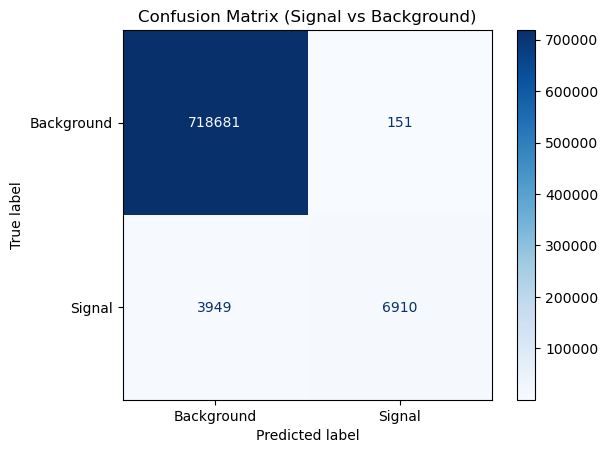

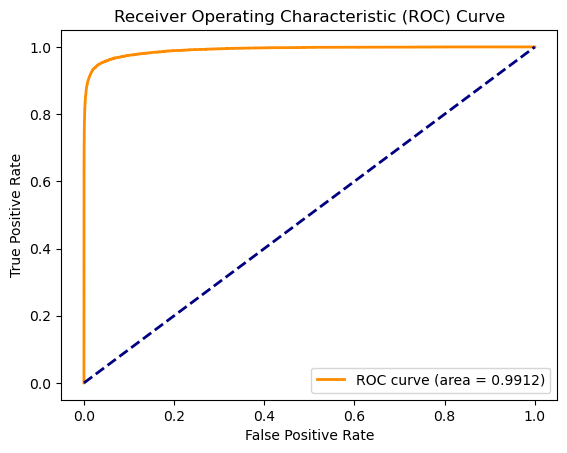

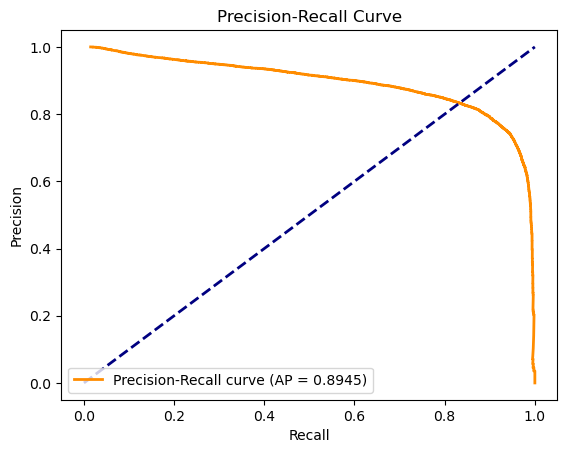

In [117]:
# getting y_pred for displays
y_pred = bdt.predict_proba(X_test) # TODO: might want to encapsulate this 
# y_pred = bdt.predict(X_test) # TODO: might want to encapsulate this 
# Displays
display_cf_matrix(y_test, y_pred, class_names=None, normalization=False)
display_roc_curve(y_test, y_pred)
display_pr_curve(y_test, y_pred)

In [118]:
# Save trained model
bdt.save_model("rare_decay_bdt0.pkl")

Model saved to: rare_decay_bdt0.pkl


In [28]:
# loading saved model
bdt = RareDecayBDTClassifier.load_model('rare_decay_bdt0.pkl')

# default evaluation
roc_auc, pr_auc, f1, accuracy = bdt.evaluate(X_test, y_test, sample_weights=weights_test) # TODO: try returning y_pred for displays or making displays encapsulated
print(f'ROC AUC score: {roc_auc:.4f}')
print(f'PR AUC score: {pr_auc:.4f}')
print(f'F1 score: {f1:.4f}')
print(f'Accuracy score: {accuracy:.4f}')

Model loaded from: rare_decay_bdt0.pkl
Something is wrong in Transform_dataset or no transformation was done!!!
ROC AUC score: 0.9941
PR AUC score: 0.8945
F1 score: 0.7921
Accuracy score: 0.9989


In [ ]:
### TODO: comparing the performance wwhether using log-scaling, normalization, or both

In [ ]:
### TODO: hyperparameters for searching --> Tuning
param_grid = {
        #'n_estimator':[50,100,200],
        'max_depth':[9],
        'learning_rate':[0.35],
        'min_child_weight':[1.4],
        'gamma':[0.5],
        'scale_pos_weight':[0.7],
        'subsample':[0.85],
        'colsample_bytree':[0.7],
        #'early_stopping_rounds': [10,20,30],
        'num_parallel_tree':[8],
        'reg_lambda':[3]
}

In [ ]:
### TODO: Implementing the Cross-Validation and StratifiedKFold
# custom ROC and PR curves across folds

In [ ]:
# random_seed = 135
# sigfile = ur.open('train_sig_rare_lowQ_wPreselBDT_v6.root')
# bkgfile = ur.open('train_bkg_data_sideBands_lowQ_wPreselBDT_v5.root')

# features = ['Bprob', 'BsLxy', 'L2iso/L2pt', 'Bcos', 'Kiso/Kpt', 'LKdz', 'LKdr', 'Passymetry', 'Kip3d/Kip3dErr', 'L1id', 'L2id']
# sample_weights = 'trig_wgt'
# preselection = '(KLmassD0 > 2.) & ((Mll>1.05) & (Mll<2.45))'

# sig_dict = sigfile['mytree'].arrays(features, library='np', cut=preselection)
# bkg_dict = bkgfile['mytree'].arrays(features, library='np', cut=preselection)

# backgr = np.stack(list(bkg_dict.values()))
# signal = np.stack(list(sig_dict.values()))

# sig_weight = sigfile['mytree'].arrays(sample_weights, library='np', cut=preselection)[sample_weights]
# bkg_weight = np.ones(backgr.shape[1])

# X = np.transpose(np.concatenate((signal, backgr), axis=1))
# y = np.concatenate((np.ones(signal.shape[1]), np.zeros(backgr.shape[1])))
# weights = np.concatenate((sig_weight, bkg_weight))

In [ ]:
# X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.05, random_state=random_seed)
# eval_set = ((X_train, y_train), (X_test, y_test))

# # skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed) #shuffle effect?

# # # Old BDT
# # bdt_old = XGBClassifier(
# #         max_depth=6,
# #         n_estimators=300,
# #         learning_rate=0.1,
# #         min_child_weight=1.,
# #         gamma=3.,
# #         subsample=1.,
# #         scale_pos_weight=1.,
# #         objective='binary:logitraw',
# #         eval_metric=['logloss','auc','aucpr'],
# # )

# # # Train old bdt with same X_train/y_train/weights_train
# # bdt_old.fit(X_train, y_train, eval_set=eval_set,sample_weight=weights_train, verbose=2)